# Linear Models

In [1]:
# Magic Commands
%matplotlib inline

# Third-Party Packages
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Lasso, LinearRegression, Ridge, SGDRegressor, SGDClassifier
from sklearn.metrics import confusion_matrix, log_loss, mean_squared_error
from sklearn.model_selection import cross_validate, KFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures

# Local Packages
from utils import plot_confusion_matrix

In [2]:
# Matplotlib Default Configuration
mpl.rc('axes', titlesize=8)
mpl.rc('grid', linestyle=':')

In [3]:
# Constants
FIG_WIDTH, FIG_HEIGHT = 11, 4

## Simple Linear Regression

### Introductory Example

In [4]:
data = pd.read_csv('../datasets/demos/rental-prices.csv')
X, y = data[['apartment_size']], data['rental_price']

In [5]:
table = data.loc[:, ['apartment_size', 'rental_price']]
table.loc[:, ['apartment_size', 'rental_price']] = table.loc[:, ['apartment_size', 'rental_price']].applymap(lambda x: f'{x:.2f}')
table = pd.concat([table.iloc[:3], pd.DataFrame([['...'] * len(table.columns)], columns=table.columns, index=[3]), table.iloc[-1:]]).reset_index(drop=True)
table.columns = ['Apartment Size', 'Rental Price']
table.insert(0, 'Apartment No.', [*range(1, 4), '...', len(data)])
table.to_latex('../slides/tables/rental-prices-slr-dataset.tex', column_format='crr', index=False, escape=False)

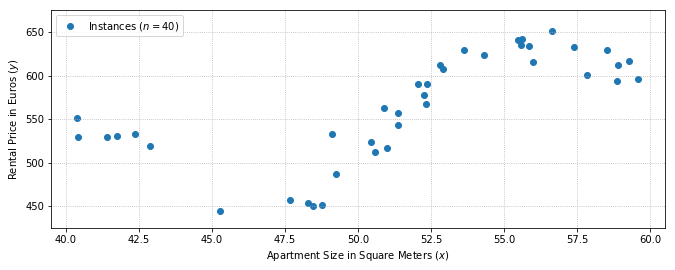

In [6]:
fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_HEIGHT))

ax.scatter(X, y, label=f'Instances ($n={len(X)}$)')

ax.set_xlabel('Apartment Size in Square Meters $(x)$')
ax.set_ylabel('Rental Price in Euros $(y)$')
ax.set_ylim(425, 675)
ax.set_xlim(39.5, 60.5)

ax.grid()
ax.legend()

plt.savefig('../slides/figures/rental-prices-slr-visualization.pdf', transparent=True, bbox_inches='tight', pad_inches=0)

### Optimization

In [7]:
se = lambda y_true, y_pred: np.square(y_true - y_pred)
sse = lambda y_true, y_pred: np.sum(se(y_true, y_pred))
mse = lambda y_true, y_pred: sse(y_true, y_pred) / len(y_true)
rmse = lambda y_true, y_pred: np.sqrt(mse(y_true, y_pred))

hypothesis_lr = lambda X, parameters: np.insert(X.values, 0, 1, axis=1).dot(parameters)
loss_func_sse = lambda y_true, y_pred: 0.5 * sse(y_true, y_pred)

hypothesis_slr_str = lambda x: f'${parameters[0]} + {parameters[1]} \cdot {x[0]:.2f} =  {x[1]:.2f}$'
se_str = lambda x: f'$({x[0]:.2f} - {x[1]:.2f})^2 = {x[2]:.2f}$'

parameter_set = [[2, 5], [3, 7]]

In [8]:
table = data.loc[:, ['apartment_size', 'rental_price']]
for idx, parameters in enumerate(parameter_set):
    idx = str(idx)
    table['h' + idx] = hypothesis_lr(table[['apartment_size']], parameters)
    table['h_str' + idx] = table[['apartment_size', 'h' + idx]].apply(hypothesis_slr_str, axis=1)
    table['se' + idx] = se(table['rental_price'], table['h' + idx])
    table['se_str' + idx] = table[['rental_price', 'h' + idx, 'se' + idx]].apply(se_str, axis=1)
    print(f"Loss function value for {parameters}: {loss_func_sse(table['rental_price'].values, table['h' + idx].values):.2f}")
table
table.loc[:, ['apartment_size', 'rental_price', 'h0', 'se0', 'h1', 'se1']] = table.loc[:, ['apartment_size', 'rental_price', 'h0', 'se0', 'h1', 'se1']].applymap(lambda x: f'{x:,.2f}')
table = pd.concat([table.iloc[:3], pd.DataFrame([['...'] * len(table.columns)], columns=table.columns, index=[3]), table.iloc[-1:]]).reset_index(drop=True)
table.columns = ['$x^{(i)}$', '$y^{(i)}$', '$\hat y^{(i)}$ [I]', '$\hat y^{(i)} = h(x^{(i)})$ [I]', '$\epsilon^{(i)}$ [I]', '$\epsilon^{(i)}$ [I]', '$\hat y^{(i)}$ [II]', '$\hat y^{(i)} = h(x^{(i)})$ [II]', '$\epsilon^{(i)}$ [II]', '$\epsilon^{(i)}$ [II]']
table.insert(0, '$i$', [*range(1, 4), '...', len(data)])
table.iloc[:, [0, 1, 2, 4, 6, 7, 9]].to_latex(f'../slides/tables/rental-prices-slr-loss-calculation.tex', column_format='crrrrrr', index=False, escape=False)
table.iloc[:, [0, 1, 2, 3, 5, 7, 9]].to_latex(f'../slides/tables/rental-prices-slr-loss-calculation-alt.tex', column_format='crrrrrr', index=False, escape=False)

Loss function value for [2, 5]: 1905671.37
Loss function value for [3, 7]: 848521.78


### Loss Function Visualization

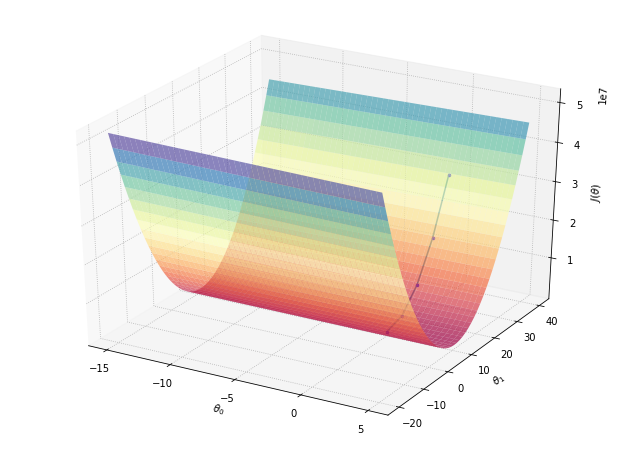

In [9]:
fig = plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT * 2))

parameters = np.linspace(-15, 5), np.linspace(-20, 40)
pX, pY = np.meshgrid(*parameters)
pZ = np.array([loss_func_sse(y, hypothesis_lr(X, parameters)) for parameters in zip(np.ravel(pX), np.ravel(pY))]).reshape(pX.shape)

ptX, ptY = np.linspace(0, 0, 5), np.linspace(35, 10, 5)
ptZ = np.array([loss_func_sse(y, hypothesis_lr(X, parameters)) for parameters in zip(np.ravel(ptX), np.ravel(ptY))]).reshape(ptX.shape)

ax = fig.add_subplot(111, projection='3d')

ax.plot(ptX, ptY, ptZ, markerfacecolor='b', markeredgecolor='b', marker='.', markersize=5)
ax.plot_surface(pX, pY, pZ, rstride=1, cstride=1, cmap=mpl.cm.Spectral, alpha=0.7)

ax.set_xlabel('$\\theta_0$')
ax.set_ylabel('$\\theta_1$')
ax.set_zlabel('$J(\\theta)$', linespacing=20)
ax.set_xticks(np.arange(-15, 10, 5))
ax.set_yticks(np.arange(-20, 50, 10))

plt.savefig('../slides/figures/rental-prices-slr-loss-function-visualization.pdf', transparent=True, bbox_inches='tight', pad_inches=0)

### Gradient Field

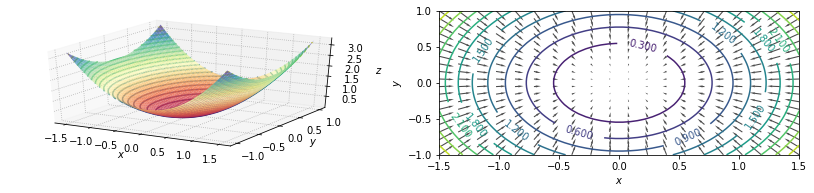

In [10]:
fig = plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT / 2))

z = lambda x, y: np.power(x, 2) + np.power(y, 2)
zdiff = lambda x, y: [2 * x, 2 * y]

parameters = np.linspace(-1.5, 1.5), np.linspace(-1, 1)
pX, pY = np.meshgrid(parameters[0], parameters[1])
aX, aY = np.meshgrid(np.linspace(-1.5, 1.5, 20), np.linspace(-1, 1, 20))
pZ = np.array([z(parameters[0], parameters[1]) for parameters in zip(np.ravel(pX), np.ravel(pY))]).reshape(pX.shape)

ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(pX, pY, pZ, rstride=1, cstride=1, cmap=mpl.cm.Spectral, alpha=0.8)
ax1.contour(pX, pY, pZ, 30)
ax1.set_xlabel('$x$')
ax1.set_ylabel('$y$')
ax1.set_zlabel('$z$')
ax1.set_yticks(np.arange(-1, 1.5, 0.5))

ax2 = fig.add_subplot(122)
ax2.quiver(aX, aY, -zdiff(aX, aY)[0], -zdiff(aX, aY)[1], alpha=.7, headwidth=2)
contours = ax2.contour(pX, pY, pZ, 10)
ax2.clabel(contours)
ax2.set_xlabel('$x$')
ax2.set_ylabel('$y$')
    
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
plt.savefig('../slides/figures/gradient-field.pdf', transparent=True, bbox_inches='tight', pad_inches=0)

### Local and Global Optimum

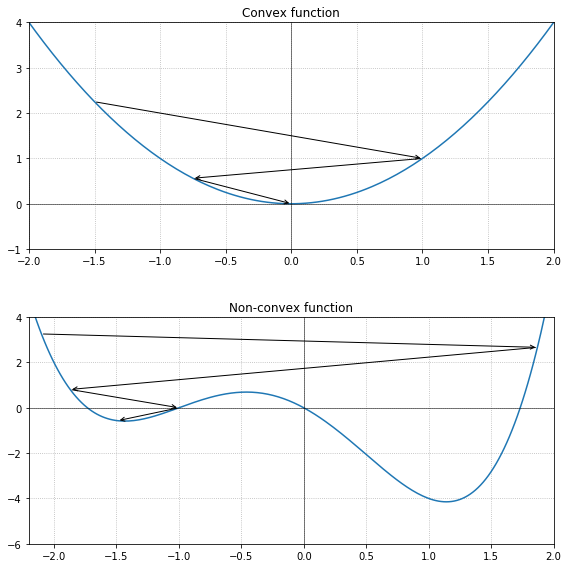

In [11]:
fig = plt.figure(figsize=(8, 8))

func_convex = lambda x: np.power(x, 2)
func_nonconvex = lambda x: np.power(x, 4) + np.power(x, 3) - 3 * np.power(x, 2) - 3 * x
pX = np.linspace(-10, 11, 1000)

ax = fig.add_subplot(211)
ax.plot(pX, func_convex(pX))
plt.annotate('', xy=(1, func_convex(1)), xytext=(-1.5, func_convex(-1.5)), arrowprops=dict(arrowstyle="->"))
plt.annotate('', xy=(-0.75, func_convex(-0.75)), xytext=(1, func_convex(1)), arrowprops=dict(arrowstyle="->"))
plt.annotate('', xy=(0, 0), xytext=(-0.75, func_convex(-0.75)), arrowprops=dict(arrowstyle="->"))
ax.set_xlim(-2, 2)
ax.set_ylim(-1, 4)
ax.axhline(y=0, color='k', linewidth=.5)
ax.axvline(x=0, color='k', linewidth=.5)
ax.set_title('Convex function', fontsize=12)
ax.grid()

ax = fig.add_subplot(212)
ax.plot(pX, func_nonconvex(pX))
plt.annotate('', xy=(1.87, func_nonconvex(1.87)), xytext=(-2.1, func_nonconvex(-2.1)), arrowprops=dict(arrowstyle="->"))
plt.annotate('', xy=(-1.87, func_nonconvex(-1.87)), xytext=(1.87, func_nonconvex(1.87)), arrowprops=dict(arrowstyle="->"))
plt.annotate('', xy=(-1, func_nonconvex(-1)), xytext=(-1.87, func_nonconvex(-1.87)), arrowprops=dict(arrowstyle="->"))
plt.annotate('', xy=(-1.49, func_nonconvex(-1.49)), xytext=(-1, func_nonconvex(-1)), arrowprops=dict(arrowstyle="->"))

ax.set_xlim(-2.2, 2)
ax.set_ylim(-6, 4)
ax.axhline(y=0, color='k', linewidth=.5)
ax.axvline(x=0, color='k', linewidth=.5)
ax.grid()
ax.set_title('Non-convex function', fontsize=12)

plt.tight_layout()
plt.subplots_adjust(hspace=0.3)
plt.savefig('../slides/figures/convexity.pdf', transparent=True)

### Solution to the Rental Price Problem

In [12]:
hyperparams = {'loss': 'squared_loss', 'penalty': 'none', 'alpha':0.0001, 'max_iter': 1000, 'tol': 1e-3, 'random_state': 1909, 'eta0': 0.0001}
model = SGDRegressor(**hyperparams)
model = model.fit(X, y)

res_params = [*model.intercept_.tolist(), *model.coef_.tolist()]
print(f'Learned Parameters: {res_params}')

res_loss_function = np.sum(np.power(y - model.predict(X), 2)) * 0.5
print(f'Loss Function Value: {res_loss_function:.2f}')

prediction = model.predict([[44]])
print(f'Prediction for a 44sqm Apartment: {prediction[0]:.2f} EUR')

Learned Parameters: [0.24185631513843506, 10.94916974514499]
Loss Function Value: 44950.53
Prediction for a 44sqm Apartment: 482.01 EUR


In [6]:
%%writefile ../slides/snippets/rental-prices-slr-fitting-1.py
# Import Definitions
import numpy as np
import pandas as pd
from sklearn.linear_model import SGDRegressor

# Dataset Import
data = pd.read_csv(
    'https://raw.githubusercontent.com/saschaschworm/big-data-and-data-science/'
    'master/datasets/demos/rental-prices.csv')

# Datset Split into Feature Matrix X and Target Vector y
X, y = data[['apartment_size']], data['rental_price']

# Hyperparameter Definitions
hyperparams = {'loss': 'squared_loss', 'penalty': 'none', 'alpha': 0.0001, 'max_iter': 1000, 
               'tol': 1e-3, 'random_state': 1909, 'eta0': 0.0001}

# Model Initialization and Fitting
model = SGDRegressor(**hyperparams)
model = model.fit(X, y)

Overwriting ../slides/snippets/rental-prices-slr-fitting-1.py


In [14]:
%%writefile ../slides/snippets/rental-prices-slr-fitting-2.py
# Prediction Output
prediction = model.predict([[44]])
print(f'Prediction for a 44sqm Apartment: {prediction[0]:.2f} EUR')
> Prediction for a 44sqm Apartment: 482.01 EUR
    
# Parameter Output
res_params = [*model.intercept_.tolist(), *model.coef_.tolist()]
print(f'Learned Parameters: {res_params}')
> Learned Parameters: [0.24185631513843506, 10.94916974514499]

# Loss Function Calculation and Output
res_loss_function = np.sum(np.power(y - model.predict(X), 2)) * 0.5
print(f'Loss Function Value: {res_loss_function:.2f}')
> Loss Function Value: 44950.53

Overwriting ../slides/snippets/rental-prices-slr-fitting-2.py


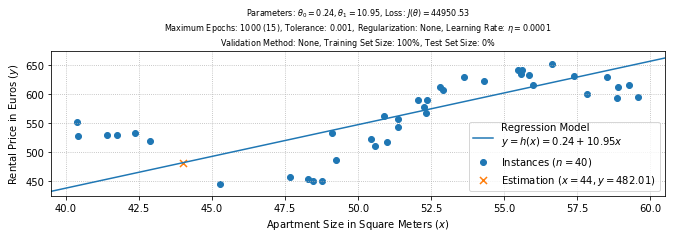

In [15]:
fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_HEIGHT / 1.5))

X_regression_line = np.linspace(35, 65, 100)[:, np.newaxis]
y_regression_line = model.predict(X_regression_line)

title = \
    f'Parameters: $\\theta_0={res_params[0]:.2f}, \\theta_1={res_params[1]:.2f}$, Loss: $J(\\theta)={res_loss_function:.2f}$\n' \
    f'Maximum Epochs: {model.max_iter} ({model.n_iter_}), Tolerance: {model.tol}, Regularization: {model.penalty.capitalize()}, Learning Rate: $\\eta={model.eta0}$\n' \
    f'Validation Method: None, Training Set Size: $100\\%$, Test Set Size: $0\\%$'

ax.scatter(X, y, label=f'Instances ($n={len(X)}$)')
ax.plot(X_regression_line, y_regression_line, label=f'Regression Model\n$y=h(x)={res_params[0]:.2f} + {res_params[1]:.2f}x$')
ax.scatter(44, prediction, marker='x', label=f'Estimation ($x=44, y={prediction[0]:.2f}$)', s=50)

ax.set_xlabel('Apartment Size in Square Meters $(x)$')
ax.set_ylabel('Rental Price in Euros $(y)$')
ax.set_ylim(425, 675)
ax.set_xlim(39.5, 60.5)

ax.set_title(title)
ax.legend()
ax.grid()

plt.savefig('../slides/figures/rental-prices-slr-solution.pdf', transparent=True, bbox_inches='tight', pad_inches=0)

### Root Mean Squared Error

In [16]:
res_rmse = np.sqrt(mean_squared_error(y, model.predict(X)))
print(f'RMSE on the Training Set: {res_rmse:.2f} EUR')

RMSE on the Training Set: 47.41 EUR


In [17]:
%%writefile ../slides/snippets/rental-prices-slr-rmse.py
# Additional Import Definitions
from sklearn.metrics import mean_squared_error

# RMSE Calculation and Output
res_rmse = np.sqrt(mean_squared_error(y, model.predict(X)))
print(f'RMSE on the Training Set: {res_rmse:.2f} EUR')
> RMSE on the Training Set: 47.41 EUR

Overwriting ../slides/snippets/rental-prices-slr-rmse.py


### Holdout Method

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1909)
model = model.fit(X_train, y_train)
y_pred_tr, y_pred_te = model.predict(X_train), model.predict(X_test)

res_rmse_tr, res_rmse_te = np.sqrt(mean_squared_error(y_train, y_pred_tr)), np.sqrt(mean_squared_error(y_test, y_pred_te))
print(f'RMSE on Training and Test Set: {res_rmse_tr:.2f}/{res_rmse_te:.2f} EUR')

RMSE on Training and Test Set: 50.58/36.41 EUR


In [19]:
%%writefile ../slides/snippets/rental-prices-slr-holdout-method.py
# Additional Import Definitions
from sklearn.model_selection import train_test_split

# Feature Matrix and Target Vector Split into Training and Test Set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1909)

# Model Refitting
model = model.fit(X_train, y_train)

# Prediction for Training and Test Set Features
y_pred_tr, y_pred_te = model.predict(X_train), model.predict(X_test) 

# RMSE Calculation and Output for Training and Test Set
res_rmse_tr = np.sqrt(mean_squared_error(y_train, y_pred_tr))
res_rmse_te = np.sqrt(mean_squared_error(y_test, y_pred_te))
print(f'RMSE on Training and Test Set: {res_rmse_tr:.2f}/{res_rmse_te:.2f} EUR')
> RMSE on Training and Test Set: 50.58/36.41 EUR

Overwriting ../slides/snippets/rental-prices-slr-holdout-method.py


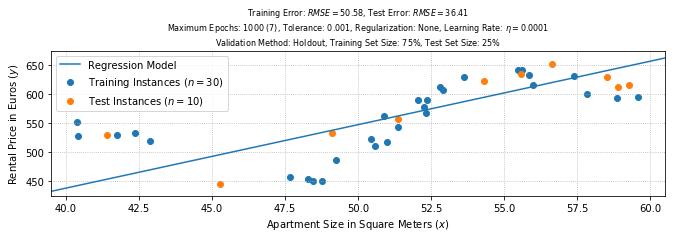

In [20]:
fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_HEIGHT / 1.5))

title = \
    f'Training Error: $RMSE={res_rmse_tr:.2f}$, Test Error: $RMSE={res_rmse_te:.2f}$\n' \
    f'Maximum Epochs: {model.max_iter} ({model.n_iter_}), Tolerance: {model.tol}, Regularization: {model.penalty.capitalize()}, Learning Rate: $\\eta={model.eta0}$\n' \
    f'Validation Method: Holdout, Training Set Size: $75\\%$, Test Set Size: $25\\%$'

ax.scatter(X_train, y_train, label=f'Training Instances ($n={len(X_train)}$)')
ax.scatter(X_test, y_test, label=f'Test Instances ($n={len(X_test)}$)')
ax.plot(X_regression_line, y_regression_line, label=f'Regression Model')

ax.set_xlabel('Apartment Size in Square Meters $(x)$')
ax.set_ylabel('Rental Price in Euros $(y)$')
ax.set_ylim(425, 675)
ax.set_xlim(39.5, 60.5)

ax.set_title(title)
ax.legend()
ax.grid()

plt.savefig('../slides/figures/rental-prices-slr-holdout-method.pdf', transparent=True, bbox_inches='tight', pad_inches=0)

### k-Fold Cross Validation

In [21]:
scoring = 'neg_mean_squared_error'
res_cv = cross_validate(estimator=model, X=X, y=y, scoring=scoring, cv=10, return_train_score=True)
res_rmse_tr = np.mean(np.sqrt(np.abs(res_cv['train_score'])))
res_rmse_te = np.mean(np.sqrt(np.abs(res_cv['test_score'])))
print(f'Average RMSE on Training and Test Set: {res_rmse_tr:.2f}/{res_rmse_te:.2f} EUR')

Average RMSE on Training and Test Set: 47.28/45.58 EUR


In [22]:
%%writefile ../slides/snippets/rental-prices-slr-kfold-method.py
# Additional Import Definitions
from sklearn.model_selection import cross_validate

# 10-Fold Cross-Validation with RMSE Scoring Metric
scoring = 'neg_mean_squared_error'
res_cv = cross_validate(model, X, y, scoring=scoring, cv=10, return_train_score=True)

# RMSE Calculation and Output for Training and Test Set
res_rmse_tr = np.mean(np.sqrt(np.abs(res_cv['train_score'])))
res_rmse_te = np.mean(np.sqrt(np.abs(res_cv['test_score'])))
print(f'Average RMSE on Training and Test Set: {res_rmse_tr:.2f}/{res_rmse_te:.2f} EUR')
> Average RMSE on Training and Test Set: 47.28/45.58 EUR

Overwriting ../slides/snippets/rental-prices-slr-kfold-method.py


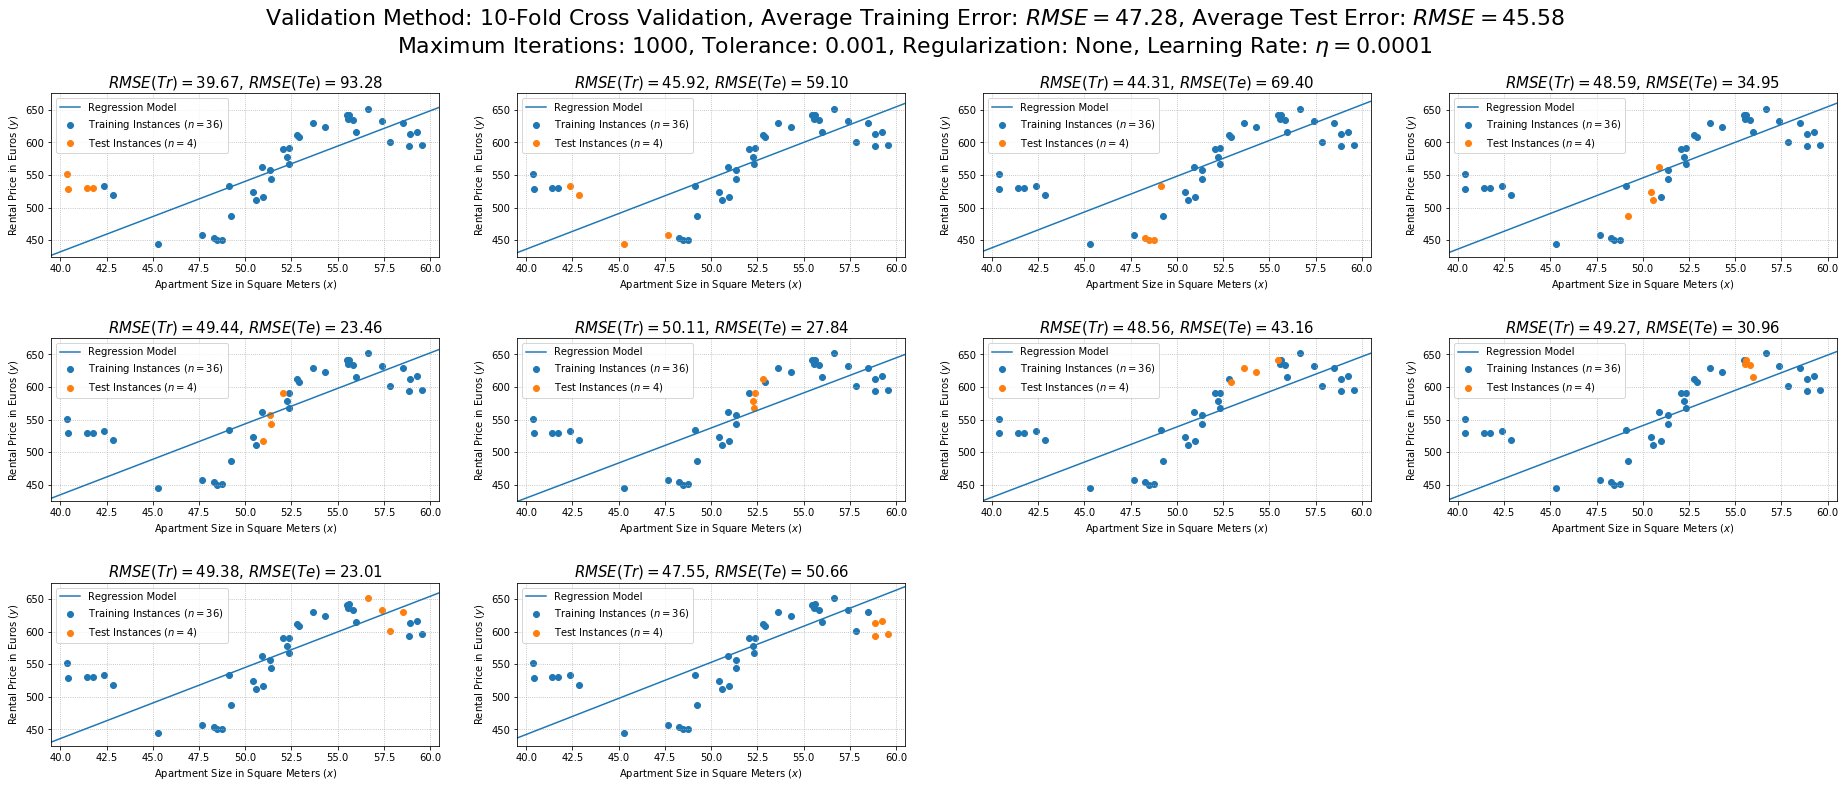

In [23]:
fig = plt.figure(figsize=(32, 12))

k_fold_cv = KFold(n_splits=10, random_state=1909)
params, loss_rmses_tr, loss_rmses_te = [], [], []

for idx, indices in enumerate(k_fold_cv.split(X)):
    train_index, test_index = indices
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model.fit(X_train, y_train)
    
    parameters = np.concatenate((model.intercept_, model.coef_))
    params.append(parameters)

    y_pred_tr, y_pred_te = model.predict(X_train), model.predict(X_test)

    loss_rmse_tr, loss_rmse_te = np.sqrt(mean_squared_error(y_train, y_pred_tr)), np.sqrt(mean_squared_error(y_test, y_pred_te))
    loss_rmses_tr.append(loss_rmse_tr), loss_rmses_te.append(loss_rmse_te)
    
    X_regression_line = np.linspace(35, 65, 100)[:, np.newaxis]
    y_regression_line = model.predict(X_regression_line)

    title = f'$RMSE(Tr)={loss_rmse_tr:.2f}$, $RMSE(Te)={loss_rmse_te:.2f}$'
    ax = fig.add_subplot(3, 4, idx + 1)
    ax.scatter(X_train, y_train, label=f'Training Instances ($n={len(X_train)}$)')
    ax.scatter(X_test, y_test, label=f'Test Instances ($n={len(X_test)}$)')
    ax.plot(X_regression_line, y_regression_line, label=f'Regression Model')

    ax.set_xlabel('Apartment Size in Square Meters $(x)$')
    ax.set_ylabel('Rental Price in Euros $(y)$')
    ax.set_ylim(425, 675)
    ax.set_xlim(39.5, 60.5)

    ax.set_title(title, fontsize=15)

    ax.legend()
    ax.grid()
    
suptitle = \
    f'Validation Method: {k_fold_cv.n_splits}-Fold Cross Validation, Average Training Error: $RMSE={np.mean(loss_rmses_tr):.2f}$, Average Test Error: $RMSE={np.mean(loss_rmses_te):.2f}$\n' \
    f'Maximum Iterations: {model.max_iter}, Tolerance: {model.tol}, Regularization: {model.penalty.capitalize()}, Learning Rate: $\\eta={model.eta0}$'

fig.suptitle(suptitle, fontsize=22)
plt.subplots_adjust(hspace=0.5)
plt.savefig('../slides/figures/rental-prices-slr-kfold-method.pdf', transparent=True, bbox_inches='tight')

In [24]:
k_fold_overview = []
for idx, rmse_tr, rmse_te, param in zip(list(range(1,11)), loss_rmses_tr, loss_rmses_te, params):
     k_fold_overview.append([idx, rmse_tr, rmse_te, param[0], param[1]])
k_fold_overview = pd.DataFrame(k_fold_overview)
k_fold_overview.columns = ['Iteration', '$\theta_0$', '$\theta_1$', '$RMSE(Tr)$', '$RMSE(Te)$']
k_fold_overview.to_latex('../slides/tables/rental-prices-slr-kfold-method-overview.tex', index=False, escape=False, column_format='ccccc')

### Underfitting

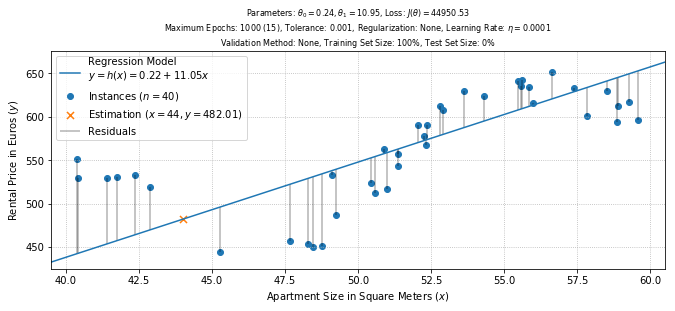

In [25]:
fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_HEIGHT))

model.fit(X, y)
res_loss_function = np.sum(np.power(y - model.predict(X), 2)) * 0.5
res_params = [*model.intercept_.tolist(), *model.coef_.tolist()]
prediction = model.predict([[44]])
X_regression_line = np.linspace(35, 65, 100)[:, np.newaxis]
y_regression_line = model.predict(X_regression_line)

title = \
    f'Parameters: $\\theta_0={res_params[0]:.2f}, \\theta_1={res_params[1]:.2f}$, Loss: $J(\\theta)={res_loss_function:.2f}$\n' \
    f'Maximum Epochs: {model.max_iter} ({model.n_iter_}), Tolerance: {model.tol}, Regularization: {model.penalty.capitalize()}, Learning Rate: $\\eta={model.eta0}$\n' \
    f'Validation Method: None, Training Set Size: $100\\%$, Test Set Size: $0\\%$'

ax.scatter(X, y, label=f'Instances ($n={len(X)}$)')
ax.plot(X_regression_line, y_regression_line, label=f'Regression Model\n$y=h(x)={parameters[0]:.2f} + {parameters[1]:.2f}x$')
ax.scatter(44, prediction, marker='x', label=f'Estimation ($x=44, y={prediction[0]:.2f}$)', s=50)
plt.vlines(X, model.predict(X), y, linestyles='solid', label='Residuals', alpha='0.3')

ax.set_xlabel('Apartment Size in Square Meters $(x)$')
ax.set_ylabel('Rental Price in Euros $(y)$')
ax.set_ylim(425, 675)
ax.set_xlim(39.5, 60.5)

ax.set_title(title)
ax.legend()
ax.grid()

plt.savefig('../slides/figures/rental-prices-slr-residuals.pdf', transparent=True, bbox_inches='tight', pad_inches=0)

## Polynomial Regression

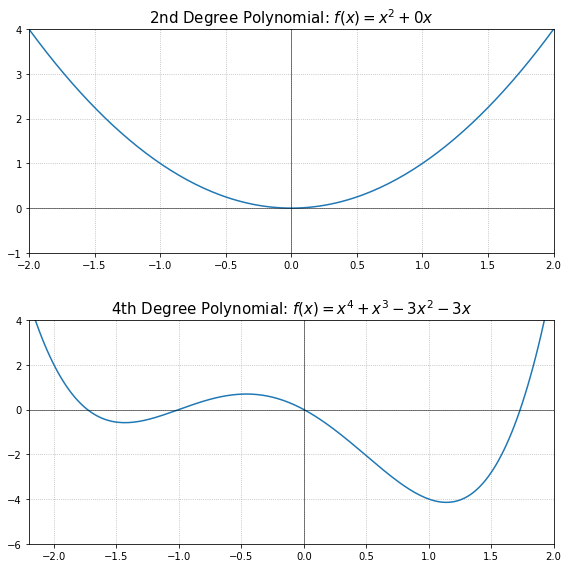

In [26]:
fig = plt.figure(figsize=(8, 8))

func_convex = lambda x: np.power(x, 2)
func_nonconvex = lambda x: np.power(x, 4) + np.power(x, 3) - 3 * np.power(x, 2) - 3 * x
pX = np.linspace(-10, 11, 1000)

ax = fig.add_subplot(211)
ax.plot(pX, func_convex(pX))
ax.set_xlim(-2, 2)
ax.set_ylim(-1, 4)
ax.axhline(y=0, color='k', linewidth=.5)
ax.axvline(x=0, color='k', linewidth=.5)
ax.set_title('2nd Degree Polynomial: $f(x) = x^2 + 0x$', fontsize=15)
ax.grid()

ax = fig.add_subplot(212)
ax.plot(pX, func_nonconvex(pX))

ax.set_xlim(-2.2, 2)
ax.set_ylim(-6, 4)
ax.axhline(y=0, color='k', linewidth=.5)
ax.axvline(x=0, color='k', linewidth=.5)
ax.grid()
ax.set_title('4th Degree Polynomial: $f(x) = x^4 + x^3 - 3x^2 - 3x$', fontsize=15)

plt.tight_layout()
plt.subplots_adjust(hspace=0.3)
plt.savefig('../slides/figures/polynomials.pdf', transparent=True)

### Development Exercise

In [27]:
%%writefile ../slides/snippets/rental-prices-pr-transformation.py
# Additional Import Definitions
from sklearn.preprocessing import PolynomialFeatures

# Polynomial Features Initialization with 3rd Degree Polynomial
polynomial_features = PolynomialFeatures(degree=3, include_bias=False)

# Transform Feature to Polynomial
Xp = polynomial_features.fit_transform(data[['apartment_size']])

Overwriting ../slides/snippets/rental-prices-pr-transformation.py


In [28]:
polynomial_features = PolynomialFeatures(degree=3, include_bias=False)
Xp = polynomial_features.fit_transform(data[['apartment_size']])

### Scale Invariance

In [29]:
invmodel1, invmodel2 = SGDRegressor(), SGDRegressor()
invcoefs11, invcoefs12, invcoefs21, invcoefs22 = [], [], [], []

for i in range(0, 100):
    invmodel1 = invmodel1.partial_fit(MinMaxScaler().fit_transform(Xp), y)
    invcoefs11.append(invmodel1.coef_[0])
    invcoefs12.append(invmodel1.coef_[2])
    
    invmodel2 = invmodel2.partial_fit(Xp, y)
    invcoefs21.append(invmodel2.coef_[0])
    invcoefs22.append(invmodel2.coef_[2])

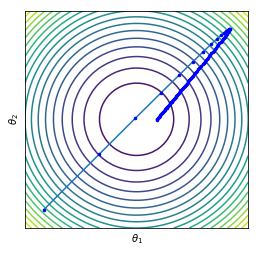

In [30]:
fig, ax = plt.subplots(figsize=(FIG_HEIGHT, FIG_HEIGHT))

z = lambda x, y: np.power(x, 2) + np.power(y, 2)
zdiff = lambda x, y: [2 * x, 2 * y]

parameters = np.linspace(-1.5, 1.5), np.linspace(-1.5, 1.5)
pX, pY = np.meshgrid(parameters[0], parameters[1])
pZ = np.array([z(parameters[0], parameters[1]) for parameters in zip(np.ravel(pX), np.ravel(pY))]).reshape(pX.shape)

ax.contour(pX, pY, pZ, 20)
ax.plot(MinMaxScaler((-1.25, 1.25)).fit_transform(np.array(invcoefs11).reshape(100, 1)), MinMaxScaler((-1.25, 1.25)).fit_transform(np.array(invcoefs12).reshape(100, 1)), markerfacecolor='b', markeredgecolor='b', marker='.', markersize=5);
ax.set_xlabel('$\\theta_1$')
ax.set_ylabel('$\\theta_2$')
ax.set_xticks([])
ax.set_yticks([])
    
plt.savefig('../slides/figures/scale-invariance-sphere.pdf', transparent=True, bbox_inches='tight', pad_inches=0)

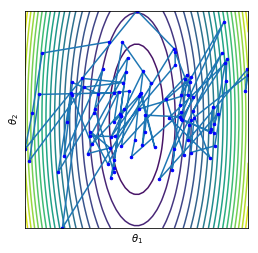

In [31]:
fig, ax = plt.subplots(figsize=(FIG_HEIGHT, FIG_HEIGHT))

z = lambda x, y: np.power(x, 2) + np.power(y, 2) / 8
zdiff = lambda x, y: [2 * x, 2 * y / 8]

parameters = np.linspace(-5, 5), np.linspace(-5, 5)
pX, pY = np.meshgrid(parameters[0], parameters[1])
pZ = np.array([z(parameters[0], parameters[1]) for parameters in zip(np.ravel(pX), np.ravel(pY))]).reshape(pX.shape)

ax.contour(pX, pY, pZ, 20)
ax.plot(MinMaxScaler((-5, 5)).fit_transform(np.array(invcoefs21).reshape(100, 1)), MinMaxScaler((-5, 5)).fit_transform(np.array(invcoefs22).reshape(100, 1)), markerfacecolor='b', markeredgecolor='b', marker='.', markersize=5);

ax.set_xlabel('$\\theta_1$')
ax.set_ylabel('$\\theta_2$')
ax.set_xticks([])
ax.set_yticks([])

plt.savefig('../slides/figures/scale-invariance-curvature.pdf', transparent=True, bbox_inches='tight', pad_inches=0)

### Normalization

In [32]:
table = pd.DataFrame(Xp)
table['$y^{(i)}$'] = y
table = table.applymap(lambda x: f'{x:.2f}')
table = pd.concat([table.iloc[:3], pd.DataFrame([['...'] * len(table.columns)], columns=table.columns, index=[3]), table.iloc[-1:]]).reset_index(drop=True)
table.columns = ['$x_1^{1(i)}$', '$x_1^{2(i)}$', '$x_1^{3(i)}$', '$y^{(i)}$']
table.insert(0, '$i$', [*range(1, 4), '...', len(data)])
table.to_latex('../slides/tables/rental-prices-pr-polynomials-overview.tex', column_format='crrrr', index=False, escape=False)

In [33]:
table

,$i$,$x_1^{1(i)}$,$x_1^{2(i)}$,$x_1^{3(i)}$,$y^{(i)}$
0,1,40.38,1630.54,65841.38,551.73
1,2,40.40,1632.16,65939.26,528.99
2,3,41.42,1715.62,71060.83,529.86
3,...,...,...,...,...
4,40,59.57,3548.58,211389.20,595.94


In [34]:
numeric_features = ['apartment_size']
numeric_transformer = Pipeline([
    ('polynomials', PolynomialFeatures(degree=3, include_bias=False)),
    ('scaler', MinMaxScaler()),
])

preprocessor = ColumnTransformer([
    ('numeric_transformer', numeric_transformer, numeric_features),
])

pipeline = Pipeline([
    ('preprocessor', preprocessor), 
    ('model', SGDRegressor(max_iter=50000, penalty='none', eta0=0.01, random_state=1909))
])

pipeline = pipeline.fit(X, y)

prediction = pipeline.predict(pd.DataFrame({'apartment_size': [44]}))
print(f'Prediction for a 44sqm Apartment: {prediction[0]:.2f} EUR')

res_cv = cross_validate(pipeline, X, y, scoring=scoring, cv=10, return_train_score=True)
res_rmse_tr = np.mean(np.sqrt(np.abs(res_cv['train_score'])))
res_rmse_te = np.mean(np.sqrt(np.abs(res_cv['test_score'])))
print(f'Average RMSE on Training and Test Set: {res_rmse_tr:.2f}/{res_rmse_te:.2f} EUR')

Prediction for a 44sqm Apartment: 504.18 EUR
Average RMSE on Training and Test Set: 42.24/49.86 EUR


/Users/sascha/.local/share/virtualenvs/laboratory-LAollfle/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:1185: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


In [35]:
%%writefile ../slides/snippets/rental-prices-pr-fitting-1.py
# Additional Import Definitions
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

numeric_features = ['apartment_size']
numeric_transformer = Pipeline([
    ('polynomials', PolynomialFeatures(degree=3, include_bias=False)),
    ('scaler', MinMaxScaler()),
])

preprocessor = ColumnTransformer([
    ('numeric_transformer', numeric_transformer, numeric_features),
])

pipeline = Pipeline([
    ('preprocessor', preprocessor), 
    ('model', SGDRegressor(max_iter=50000, penalty='none', eta0=0.01, random_state=1909))
])

Overwriting ../slides/snippets/rental-prices-pr-fitting-1.py


In [36]:
%%writefile ../slides/snippets/rental-prices-pr-fitting-2.py
# Model Fitting
pipeline = pipeline.fit(X, y)

# Prediction Output
prediction = pipeline.predict(pd.DataFrame({'apartment_size': [44]}))
print(f'Prediction for a 44sqm Apartment: {prediction[0]:.2f} EUR')
> Prediction for a 44sqm Apartment: 504.18 EUR

# 10-Fold Cross-Validation with RMSE Scoring Metric
res_cv = cross_validate(pipeline, X, y, scoring=scoring, cv=10, return_train_score=True)

# RMSE Calculation and Output for Training and Test Set
res_rmse_tr = np.mean(np.sqrt(np.abs(res_cv['train_score'])))
res_rmse_te = np.mean(np.sqrt(np.abs(res_cv['test_score'])))
print(f'Average RMSE on Training and Test Set: {res_rmse_tr:.2f}/{res_rmse_te:.2f} EUR')
> Average RMSE on Training and Test Set: 42.24/49.86 EUR

Overwriting ../slides/snippets/rental-prices-pr-fitting-2.py


In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1909)
loss_rmses_tr, loss_rmses_te = [], []
degrees = [1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144]

/Users/sascha/.local/share/virtualenvs/laboratory-LAollfle/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:1185: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/Users/sascha/.local/share/virtualenvs/laboratory-LAollfle/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:1185: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/Users/sascha/.local/share/virtualenvs/laboratory-LAollfle/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:1185: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/Users/sascha/.local/share/virtualenvs/laboratory-LAollfle/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:1185: Convergence

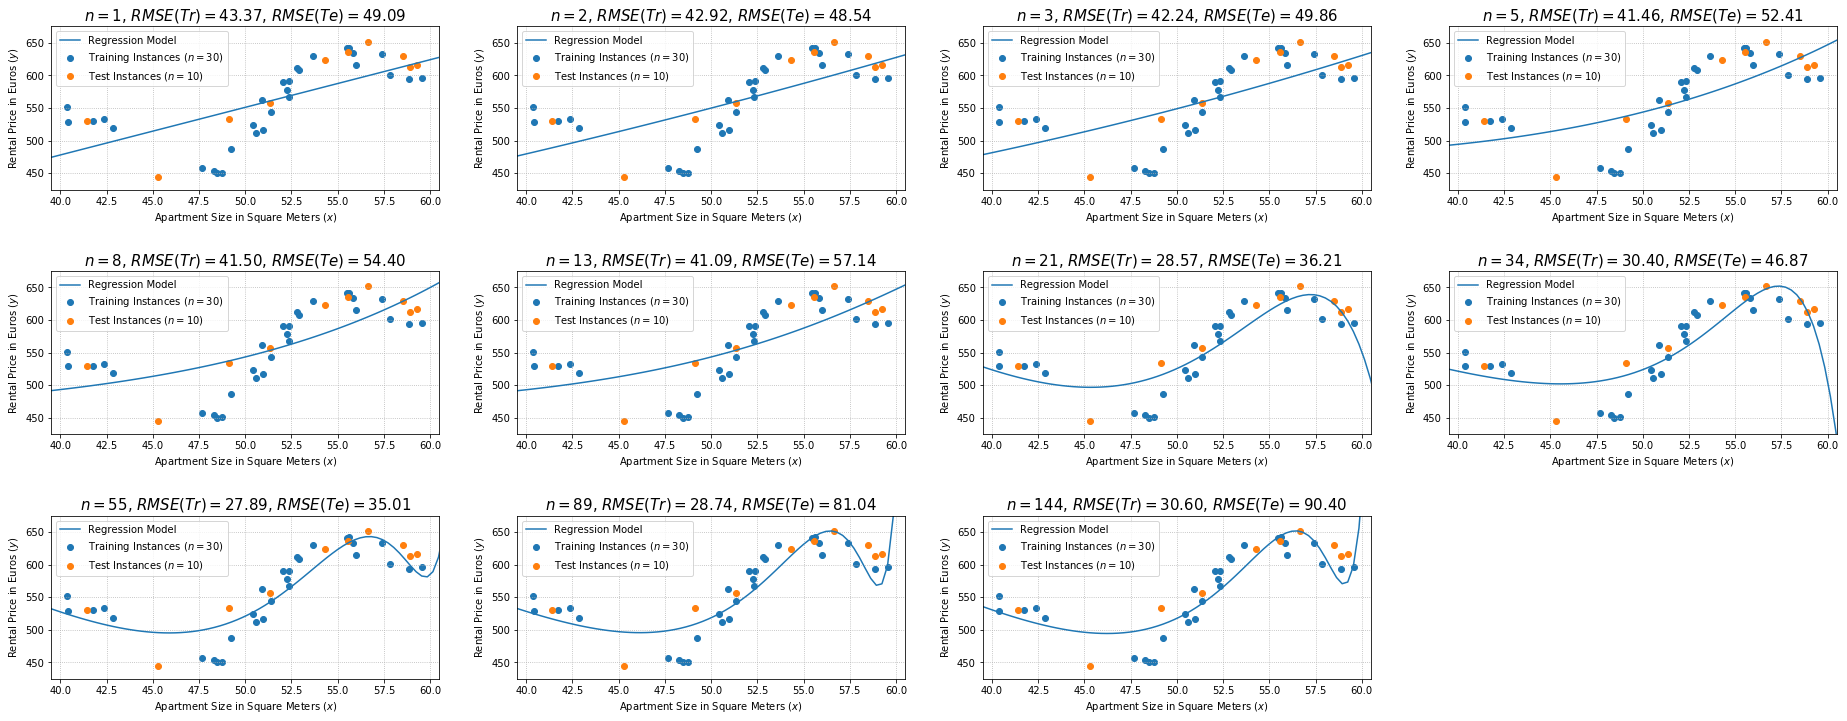

In [38]:
fig = plt.figure(figsize=(32, 12))
for idx, degree in enumerate(degrees):
    numeric_features = ['apartment_size']
    numeric_transformer = Pipeline([
        ('polynomials', PolynomialFeatures(degree=degree, include_bias=False)),
        ('scaler', MinMaxScaler()),
    ])

    preprocessor = ColumnTransformer([
        ('numeric_transformer', numeric_transformer, numeric_features),
    ])

    pipeline = Pipeline([
        ('preprocessor', preprocessor), 
        ('model', SGDRegressor(max_iter=50000, penalty='none', eta0=0.01, random_state=1909))
    ])

    pipeline.fit(X_train, y_train)    
    scoring = 'neg_mean_squared_error'
    res_cv = cross_validate(pipeline, X=X, y=y,  scoring=scoring, cv=10, return_train_score=True)
    
    loss_rmse_tr = np.mean(np.sqrt(np.abs(res_cv['train_score'])))
    loss_rmse_te = np.mean(np.sqrt(np.abs(res_cv['test_score'])))
    loss_rmses_tr.append(loss_rmse_tr), loss_rmses_te.append(loss_rmse_te)
    
    X_regression_line = np.linspace(35, 65, 100)[:, np.newaxis]
    y_regression_line = pipeline.predict(pd.DataFrame(np.linspace(35, 65, 100)[:, np.newaxis], columns=['apartment_size']))
    
    title = f'$n={degree}$, $RMSE(Tr)={loss_rmse_tr:.2f}$, $RMSE(Te)={loss_rmse_te:.2f}$'
    ax = fig.add_subplot(3, 4, idx + 1)
    ax.scatter(X_train, y_train, label=f'Training Instances ($n={len(X_train)}$)')
    ax.scatter(X_test, y_test, label=f'Test Instances ($n={len(X_test)}$)')
    ax.plot(X_regression_line, y_regression_line, label=f'Regression Model')
    
    ax.set_xlabel("Apartment Size in Square Meters $(x)$")
    ax.set_ylabel("Rental Price in Euros $(y)$")
    ax.set_ylim(425, 675)
    ax.set_xlim(39.5, 60.5)
    
    ax.set_title(title, fontsize=15)
    
    ax.legend()
    ax.grid()
    
plt.subplots_adjust(hspace=0.5)
plt.savefig('../slides/figures/rental-prices-pr-overfitting.pdf', transparent=True, bbox_inches='tight')

In [39]:
polynomials_overview = []
for degree, rmse_tr, rmse_te in zip(degrees, loss_rmses_tr, loss_rmses_te):
     polynomials_overview.append([degree, rmse_tr, rmse_te])
polynomials_overview = pd.DataFrame(polynomials_overview)
polynomials_overview.columns = ['Degree of Polynomial', '$RMSE(Tr)$', '$RMSE(Te)$']
polynomials_overview.to_latex('../slides/tables/rental-prices-pr-complexity-overview.tex', index=False, escape=False, column_format='ccc')

### Overfitting

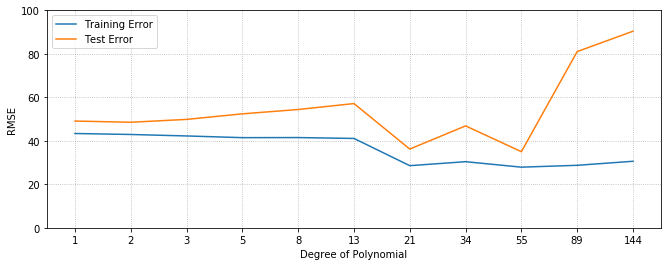

In [40]:
fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_HEIGHT))

ax.plot(range(1, 12), loss_rmses_tr, label="Training Error")
ax.plot(range(1, 12), loss_rmses_te, label="Test Error")

ax.set_xlabel('Degree of Polynomial')
ax.set_ylabel('RMSE')
ax.set_ylim(0, 100)
plt.xticks(range(1, 12), degrees)

ax.legend()
ax.grid()

plt.savefig('../slides/figures/rental-prices-pr-tradeoff.pdf', transparent=True, bbox_inches='tight', pad_inches=0)

### Regularization

In [41]:
%%writefile ../slides/snippets/regression-regularization.py
# Model Initialization with LASSO (L1)
hyperparams = {'loss': 'squared_loss', 'penalty': 'l1', 'alpha': 0.0001, 'max_iter': 1000, 
               'tol': 1e-3, 'random_state': 1909, 'eta0': 0.0001}
model = SGDRegressor(**hyperparams)

# Model Initialization with RIDGE (L2)
hyperparams = {'loss': 'squared_loss', 'penalty': 'l2', 'alpha': 0.0001, 'max_iter': 1000, 
               'tol': 1e-3, 'random_state': 1909, 'eta0': 0.0001}
model = SGDRegressor(**hyperparams)
                     
# Model Fitting
model = model.fit(X, y)

Overwriting ../slides/snippets/regression-regularization.py


#### Comparison

In [42]:
hyperparameters = {'alpha': 1.0, 'max_iter': 1000, 'tol': 1e-3, 'random_state': 1909}
polynomials = PolynomialFeatures(degree=80, include_bias=False)
l1, l2 = Lasso(**hyperparameters), Ridge(**hyperparameters),

l1_pipeline = Pipeline([("polynomials", polynomials), ("model", l1)])
l2_pipeline = Pipeline([("polynomials", polynomials), ("model", l2)])
l1_pipeline.fit(X, y), l2_pipeline.fit(X, y)

l1_cv = cross_validate(l1_pipeline, X=X, y=y,  scoring=scoring, cv=10, return_train_score=True)
l2_cv = cross_validate(l2_pipeline, X=X, y=y,  scoring=scoring, cv=10, return_train_score=True)
l1_rmse_tr = np.mean(np.sqrt(np.abs(l1_cv['train_score'])))
l1_rmse_te = np.mean(np.sqrt(np.abs(l1_cv['test_score'])))
l2_rmse_tr = np.mean(np.sqrt(np.abs(l2_cv['train_score'])))
l2_rmse_te = np.mean(np.sqrt(np.abs(l2_cv['test_score'])))

print(f'Average RMSE on Training and Test Set: {l1_rmse_tr:.2f} EUR/{l1_rmse_te:.2f} EUR')
print(f'Average RMSE on Training and Test Set: {l2_rmse_tr:.2f} EUR/{l2_rmse_te:.2f} EUR')

/Users/sascha/.local/share/virtualenvs/laboratory-LAollfle/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10990.485502361917, tolerance: 147.45766516
  positive)
/Users/sascha/.local/share/virtualenvs/laboratory-LAollfle/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/sascha/.local/share/virtualenvs/laboratory-LAollfle/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10431.916767791277, tolerance: 143.22172387499998
  positive)
/Users/sascha/.local/share/virtualenvs/laboratory-LAollfle/lib/python3.6/site-packages/sklearn/linear_mo

Average RMSE on Training and Test Set: 18.98 EUR/35.79 EUR
Average RMSE on Training and Test Set: 49.22 EUR/364.13 EUR


/Users/sascha/.local/share/virtualenvs/laboratory-LAollfle/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/sascha/.local/share/virtualenvs/laboratory-LAollfle/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/sascha/.local/share/virtualenvs/laboratory-LAollfle/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/sascha/.local/share/virtualenvs/laboratory-LAollfle/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solvin

In [43]:
models = [LinearRegression(), Lasso(), Ridge()]
methods = ['DEFAULT', 'LASSO (L1)', 'RIDGE (L2)']
loss_rmses_tr, loss_rmses_te = [], []
degree = 80

/Users/sascha/.local/share/virtualenvs/laboratory-LAollfle/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7781.722597370877, tolerance: 10.44522309366667
  positive)
/Users/sascha/.local/share/virtualenvs/laboratory-LAollfle/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10431.916767791277, tolerance: 14.322172387499997
  positive)
/Users/sascha/.local/share/virtualenvs/laboratory-LAollfle/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9359.085268071918, tolerance: 11.587628192222226
  positive)
/Users/sascha/.local/share/virtualenvs/laboratory-LAollfle/lib/python3

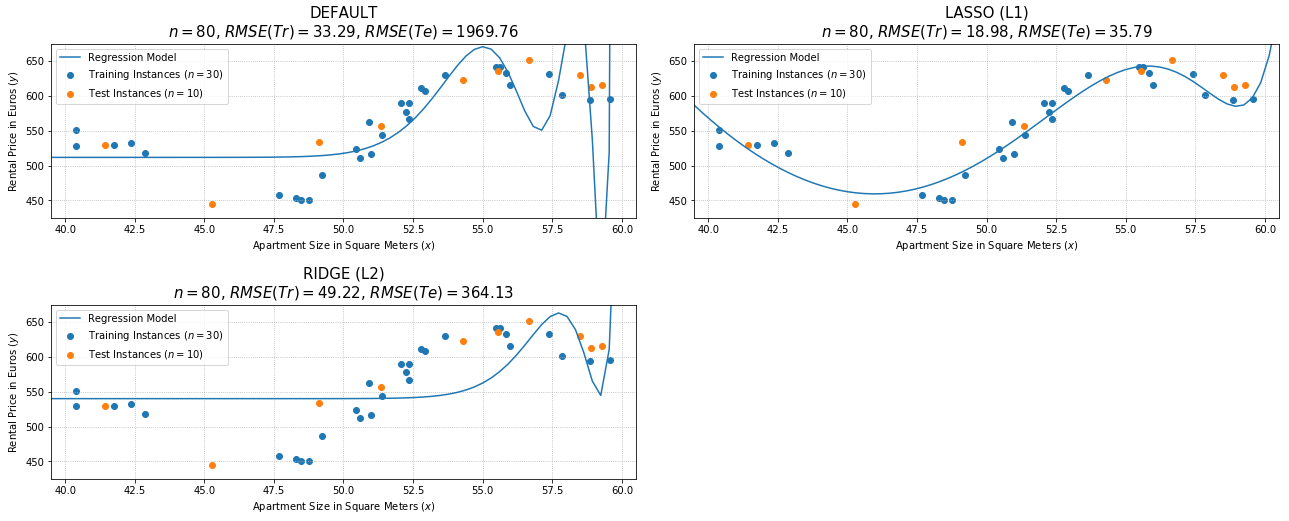

In [44]:
fig = plt.figure(figsize=(FIG_WIDTH * 2, FIG_HEIGHT * 2))
for idx, model in enumerate(models):
    model = model
    polynomial_features = PolynomialFeatures(degree=degree, include_bias=False)
    pipeline = Pipeline([("polynomial_features", polynomial_features), ("linear_regression", model)])
    pipeline.fit(X_train, y_train)
    
    y_pred_tr, y_pred_te = pipeline.predict(X_train), pipeline.predict(X_test)
        
    scoring = 'neg_mean_squared_error'
    res_cv = cross_validate(pipeline, X=X, y=y,  scoring=scoring, cv=10, return_train_score=True)
    
    loss_rmse_tr = np.mean(np.sqrt(np.abs(res_cv['train_score'])))
    loss_rmse_te = np.mean(np.sqrt(np.abs(res_cv['test_score'])))

    loss_rmses_tr.append(loss_rmse_tr), loss_rmses_te.append(loss_rmse_te)

    X_regression_line = np.linspace(35, 65, 100)[:, np.newaxis]
    y_regression_line = pipeline.predict(X_regression_line)
    
    title = f'{methods[idx]}\n$n={degree}$, $RMSE(Tr)={loss_rmse_tr:.2f}$, $RMSE(Te)={loss_rmse_te:.2f}$'
    ax = fig.add_subplot(2, 2, idx + 1)
    ax.scatter(X_train, y_train, label=f'Training Instances ($n={len(X_train)}$)')
    ax.scatter(X_test, y_test, label=f'Test Instances ($n={len(X_test)}$)')
    ax.plot(X_regression_line, y_regression_line, label=f'Regression Model')
    
    ax.set_xlabel("Apartment Size in Square Meters $(x)$")
    ax.set_ylabel("Rental Price in Euros $(y)$")
    ax.set_ylim(425, 675)
    ax.set_xlim(39.5, 60.5)

    ax.set_title(title, fontsize=15)

    ax.legend()
    ax.grid()
    
plt.subplots_adjust(hspace=0.5, wspace=0.1)
plt.savefig('../slides/figures/rental-prices-pr-regularization-effect.pdf', transparent=True, bbox_inches='tight', pad_inches=0)

In [45]:
regularization_overview = []
for method, rmse_tr, rmse_te in zip(methods, loss_rmses_tr, loss_rmses_te):
     regularization_overview.append([degree, method, rmse_tr, rmse_te])
regularization_overview = pd.DataFrame(regularization_overview)
regularization_overview.columns = ['Degree of Polynomial', 'Regularization Method', '$RMSE(Tr)$', '$RMSE(Te)$']
regularization_overview.to_latex('../slides/tables/rental-prices-pr-regularization-effect-overview.tex', index=False, escape=False, column_format='cccc')

## Multiple Linear Regression

In [46]:
table = data[['apartment_size', 'age', 'rental_price']]
table[['apartment_size', 'rental_price']] = table[['apartment_size', 'rental_price']].applymap(lambda x: f'{x:.2f}')
table = pd.concat([table.iloc[:3], pd.DataFrame([['...'] * len(table.columns)], columns=table.columns, index=[3]), table.iloc[-1:]])
table.index = [*range(1, 4), '...', len(data)]
table.reset_index(inplace=True)
table.columns = ['Apartment No.', 'Apartment Size', 'Years since Construction', 'Rental Price']
table.to_latex('../slides/tables/rental-prices-mlr-dataset.tex', column_format='crrr', index=False, escape=False)

In [47]:
X, y = data[['apartment_size', 'age']], data['rental_price']
hyperparameters = {'max_iter': 1000, 'tol': 1e-3, 'penalty': 'none', 'eta0': 0.0001, 'random_state': 1909}
model = SGDRegressor(**hyperparameters)
model = model.fit(X, y)

prediction = model.predict([[44, 10]])
print(f'Prediction for a 10-year old 44sqm Apartment: {prediction[0]:.2f} EUR')

res_cv = cross_validate(model, X, y, scoring=scoring, cv=10, return_train_score=True)
res_rmse_tr = np.mean(np.sqrt(np.abs(res_cv['train_score'])))
res_rmse_te = np.mean(np.sqrt(np.abs(res_cv['test_score'])))
print(f'Average RMSE on Training and Test Set: {res_rmse_tr:.2f} EUR/{res_rmse_te:.2f} EUR')

Prediction for a 10-year old 44sqm Apartment: 484.81 EUR
Average RMSE on Training and Test Set: 39.03 EUR/38.13 EUR


In [48]:
%%writefile ../slides/snippets/rental-prices-mlr-fitting-1.py
# Datset Split into Feature Matrix X and Target Vector y
X, y = data[['apartment_size', 'age']], data['rental_price']

# Hyperparameter Definitions
hyperparams = {'max_iter': 1000, 'tol': 1e-3, 'penalty': 'none',
                   'eta0': 0.0001, 'random_state': 1909}

# Model Initialization and Fitting
model = SGDRegressor(**hyperparams)
model = model.fit(X, y)

# Prediction Output
prediction = model.predict([[44, 10]])
print(f'Prediction for a 10-year old 44sqm Apartment: {prediction[0]:.2f} EUR')
> Prediction for a 10-year old 44sqm Apartment: 484.81 EUR

Overwriting ../slides/snippets/rental-prices-mlr-fitting-1.py


In [49]:
%%writefile ../slides/snippets/rental-prices-mlr-fitting-2.py
# 10-Fold Cross-Validation with RMSE Scoring Metric
res_cv = cross_validate(model, X, y, scoring=scoring, cv=10, return_train_score=True)

# RMSE Calculation and Output for Training and Test Set
res_rmse_tr = np.mean(np.sqrt(np.abs(res_cv['train_score'])))
res_rmse_te = np.mean(np.sqrt(np.abs(res_cv['test_score'])))
print(f'Average RMSE on Training and Test Set: {res_rmse_tr:.2f} EUR/{res_rmse_te:.2f} EUR')
> Average RMSE on Training and Test Set: 39.03 EUR/38.13 EUR

Overwriting ../slides/snippets/rental-prices-mlr-fitting-2.py


## Logistic Regression

In [50]:
data = pd.read_csv('../datasets/demos/exam-performance.csv')
X, y = data[['hours_studied', 'hours_slept']], data['passed']

In [51]:
table = data[['hours_studied', 'hours_slept', 'passed']]
table[['hours_studied', 'hours_slept']] = table[['hours_studied', 'hours_slept']].applymap(lambda x: f'{x:.2f}')
table = pd.concat([table.iloc[:3], pd.DataFrame([['...'] * len(table.columns)], columns=table.columns, index=[3]), table.iloc[-1:]])
table.index = [*range(1, 4), '...', len(data)]
table.reset_index(inplace=True)
table.columns = ['Student ID', 'Hours Studied', 'Hours Slept', 'Exam Passed']
table.to_latex('../slides/tables/exam-performance-dataset.tex', column_format='crrr', index=False, escape=False)

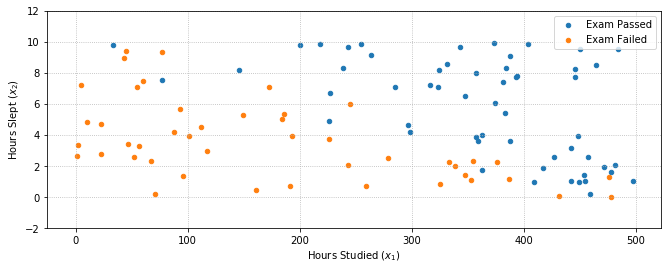

In [52]:
fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_HEIGHT))

ax.scatter(data[data['passed'] == 1].values[:,0], data[data['passed'] == 1].values[:,1], label='Exam Passed', s=20)
ax.scatter(data[data['passed'] == 0].values[:,0], data[data['passed'] == 0].values[:,1], label='Exam Failed', s=20)

ax.set_xlabel("Hours Studied $(x_1)$")
ax.set_ylabel("Hours Slept $(x_2)$")
ax.set_ylim((-2, 12))

ax.grid()
ax.legend()

plt.savefig('../slides/figures/exam-performance-visualization.pdf', transparent=True, bbox_inches='tight', pad_inches=0)

### Sigmoid Function

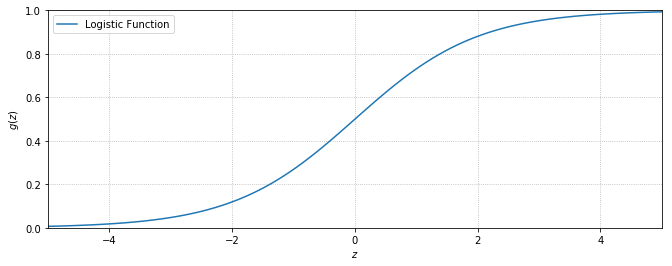

In [53]:
fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_HEIGHT))

sigmoid_function = lambda z: 1 / (1 + np.exp(-z))
z = np.linspace(-5, 5, 100)

ax.plot(z, sigmoid_function(z[:, np.newaxis]), label="Logistic Function")
ax.set_xlabel("$z$")
ax.set_ylabel("$g(z)$")
ax.set_xlim((-5, 5))
ax.set_ylim((0, 1))

ax.grid()
ax.legend()

plt.savefig('../slides/figures/sigmoid-function.pdf', transparent=True, bbox_inches='tight', pad_inches=0)

### Loss Function

/Users/sascha/.local/share/virtualenvs/laboratory-LAollfle/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/sascha/.local/share/virtualenvs/laboratory-LAollfle/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


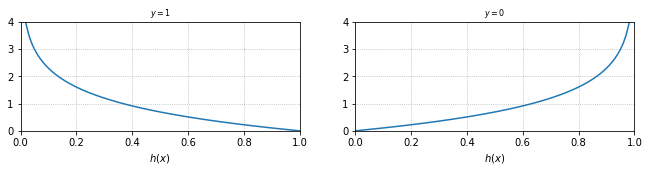

In [54]:
plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT / 2))

cost_y1 = lambda x: -np.log(x)
cost_y0 = lambda x: -np.log(1 - x)

ax1 = plt.subplot(1, 2, 1)
ax1.plot(np.linspace(0, 1, 100), cost_y1(np.linspace(0, 1, 100)), label="True function")
ax1.set_xlabel("$h(x)$")
ax1.set_xlim((0, 1))
ax1.set_ylim((0, 4))
ax1.set_title('$y=1$')
ax1.grid()

ax2 = plt.subplot(1, 2, 2)
ax2.plot(np.linspace(0, 1, 100), cost_y0(np.linspace(0, 1, 100)), label="True function")
ax2.set_xlabel("$h(x)$")
ax2.set_xlim((0, 1))
ax2.set_ylim((0, 4))
ax2.set_title('$y=0$')
ax2.grid()

plt.savefig('../slides/figures/lr-loss-function-visualization.pdf', transparent=True, bbox_inches='tight', pad_inches=0)

### Learning Process without Normalization

In [7]:
%%writefile ../slides/snippets/exam-performance-lr-fitting-1.py
# Additional Import Definitions
from sklearn.linear_model import SGDClassifier

# Dataset Import
data = pd.read_csv(
    'https://raw.githubusercontent.com/saschaschworm/big-data-and-data-science/'
    'master/datasets/demos/exam-performance.csv')

# Datset Split into Feature Matrix X and Target Vector y
X, y = data[['hours_studied', 'hours_slept']], data['passed']

# Hyperparameter Definitions
hyperparams = {'loss': 'log', 'penalty': 'none', 'alpha': 0.0001, 'max_iter': 1000, 
               'tol': 1e-3, 'random_state': 1909, 'eta0': 0.0001}

# Model Initialization and Fitting
model = SGDClassifier(**hyperparams)
model = model.fit(X, y)

Overwriting ../slides/snippets/exam-performance-lr-fitting-1.py


In [56]:
hyperparams = {'loss': 'log', 'penalty': 'none', 'alpha': 0.0001, 'max_iter': 1000, 'tol': 1e-3, 'random_state': 1909, 'eta0': 0.0001}
model = SGDClassifier(**hyperparams)
model = model.fit(X, y)

y_pred, y_pred_proba = model.predict(X), model.predict_proba(X)

scoring = 'neg_log_loss'
res_cv = cross_validate(model, X, y, scoring=scoring, cv=10, return_train_score=True)
res_logloss_tr = np.mean(np.abs(res_cv['train_score']))
res_logloss_te = np.mean(np.abs(res_cv['test_score']))
print(f'Average RMSE on Training and Test Set: {res_logloss_tr:.2f}/{res_logloss_te:.2f}')

res = pd.DataFrame({'prediction': y_pred_proba[:,1], 'actual': y})

Average RMSE on Training and Test Set: 15.81/15.84


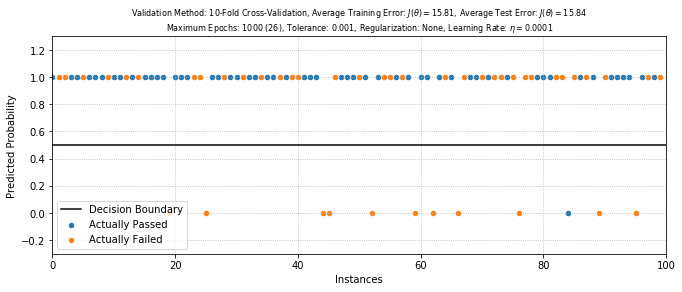

In [57]:
fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_HEIGHT))

title = \
    f'Validation Method: 10-Fold Cross-Validation, Average Training Error: $J(\\theta)={res_logloss_tr:.2f}$, Average Test Error: $J(\\theta)={res_logloss_te:.2f}$\n' \
    f'Maximum Epochs: {model.max_iter} ({model.n_iter_}), Tolerance: {model.tol}, Regularization: {model.penalty.capitalize()}, Learning Rate: $\\eta={model.eta0}$'

ax.scatter(res[res['actual'] == 1].index, res[res['actual'] == 1]['prediction'], label='Actually Passed', s=20)
ax.scatter(res[res['actual'] == 0].index, res[res['actual'] == 0]['prediction'], label='Actually Failed', s=20)
ax.axhline(.5, color='black', label='Decision Boundary')

ax.set_title(title)
ax.set_xlabel("Instances")
ax.set_ylabel("Predicted Probability")
ax.set_xlim((0, 100))
ax.set_ylim((-0.3, 1.3))

ax.legend()
ax.grid()

plt.savefig('../slides/figures/exam-performance-lr-solution-1.pdf', transparent=True, bbox_inches='tight', pad_inches=0)

### Learning Process Normalization

In [58]:
numeric_features = ['hours_studied', 'hours_slept']
numeric_transformer = Pipeline([
    ('scaler', MinMaxScaler()),
])

preprocessor = ColumnTransformer([
    ('numeric_transformer', numeric_transformer, numeric_features),
])

pipeline = Pipeline([
    ('preprocessor', preprocessor), 
    ('model', model)
])

pipeline = pipeline.fit(X, y)

In [59]:
y_pred, y_pred_proba = pipeline.predict(X), pipeline.predict_proba(X)

scoring = 'neg_log_loss'
res_cv = cross_validate(pipeline, X, y, scoring=scoring, cv=10, return_train_score=True)
res_logloss_tr = np.mean(np.abs(res_cv['train_score']))
res_logloss_te = np.mean(np.abs(res_cv['test_score']))
print(f'Average RMSE on Training and Test Set: {res_logloss_tr:.2f}/{res_logloss_te:.2f}')

res = pd.DataFrame({'prediction': y_pred_proba[:,1], 'pred_class': y_pred, 'actual': y})

Average RMSE on Training and Test Set: 0.58/0.71


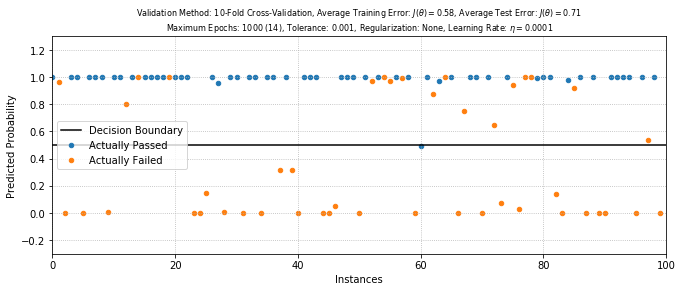

In [60]:
fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_HEIGHT))

title = \
    f'Validation Method: 10-Fold Cross-Validation, Average Training Error: $J(\\theta)={res_logloss_tr:.2f}$, Average Test Error: $J(\\theta)={res_logloss_te:.2f}$\n' \
    f'Maximum Epochs: {model.max_iter} ({model.n_iter_}), Tolerance: {model.tol}, Regularization: {model.penalty.capitalize()}, Learning Rate: $\\eta={model.eta0}$'

ax.scatter(res[res['actual'] == 1].index, res[res['actual'] == 1]['prediction'], label='Actually Passed', s=20)
ax.scatter(res[res['actual'] == 0].index, res[res['actual'] == 0]['prediction'], label='Actually Failed', s=20)
ax.axhline(.5, color='black', label='Decision Boundary')

ax.set_title(title)
ax.set_xlabel("Instances")
ax.set_ylabel("Predicted Probability")
ax.set_xlim((0, 100))
ax.set_ylim((-0.3, 1.3))

ax.legend()
ax.grid()
plt.savefig('../slides/figures/exam-performance-lr-solution-2.pdf', transparent=True, bbox_inches='tight', pad_inches=0)

### Classification Metrics

In [61]:
scoring = ['accuracy', 'recall', 'precision', 'f1']
res_cv = cross_validate(pipeline, X, y, scoring=scoring, cv=10, return_train_score=True)

res_acc_tr = np.mean(res_cv['train_accuracy']) * 100
res_acc_te = np.mean(res_cv['test_accuracy']) * 100
print(f'Average Accurarcy on Training and Test Set: {res_acc_tr:.2f}%/{res_acc_te:.2f}%')

res_rec_tr = np.mean(res_cv['train_recall']) * 100
res_rec_te = np.mean(res_cv['test_recall']) * 100
print(f'Average Recall on Training and Test Set: {res_rec_tr:.2f}%/{res_rec_te:.2f}%')

res_prec_tr = np.mean(res_cv['train_precision']) * 100
res_prec_te = np.mean(res_cv['test_precision']) * 100
print(f'Average Precision on Training and Test Set: {res_prec_tr:.2f}%/{res_prec_te:.2f}%')

res_f1_tr = np.mean(res_cv['train_f1']) * 100
res_f1_te = np.mean(res_cv['test_f1']) * 100
print(f'Average F1 on Training and Test Set: {res_f1_tr:.2f}%/{res_f1_te:.2f}%')

Average Accurarcy on Training and Test Set: 85.57%/85.45%
Average Recall on Training and Test Set: 92.93%/90.33%
Average Precision on Training and Test Set: 84.16%/87.62%
Average F1 on Training and Test Set: 87.67%/86.59%


In [62]:
%%writefile ../slides/snippets/exam-performance-lr-classification-metrics-1.py
# List Classification Metrics
scoring = ['accuracy', 'recall', 'precision', 'f1']

# 10-Fold Cross-Validation with all Scoring Metrics
res_cv = cross_validate(pipeline, X, y, scoring=scoring, cv=10, return_train_score=True)

# Accuracy Output for Training and Test Set
res_acc_tr = np.mean(res_cv['train_accuracy']) * 100
res_acc_te = np.mean(res_cv['test_accuracy']) * 100
print(f'Average Accurarcy on Training and Test Set: {res_acc_tr:.2f}%/{res_acc_te:.2f}%')
> Average Accurarcy on Training and Test Set: 85.57%/85.45%

Overwriting ../slides/snippets/exam-performance-lr-classification-metrics-1.py


In [63]:
%%writefile ../slides/snippets/exam-performance-lr-classification-metrics-2.py
# Recall Output for Training and Test Set
res_rec_tr = np.mean(res_cv['train_recall']) * 100
res_rec_te = np.mean(res_cv['test_recall']) * 100
print(f'Average Recall on Training and Test Set: {res_rec_tr:.2f}%/{res_rec_te:.2f}%')
> Average Recall on Training and Test Set: 92.93%/90.33%

# Precision Output for Training and Test Set
res_prec_tr = np.mean(res_cv['train_precision']) * 100
res_prec_te = np.mean(res_cv['test_precision']) * 100
print(f'Average Precision on Training and Test Set: {res_prec_tr:.2f}%/{res_prec_te:.2f}%')
> Average Precision on Training and Test Set: 84.16%/87.62%

# F1 Output for Training and Test Set
res_f1_tr = np.mean(res_cv['train_f1']) * 100
res_f1_te = np.mean(res_cv['test_f1']) * 100
print(f'Average F1 on Training and Test Set: {res_f1_tr:.2f}%/{res_f1_te:.2f}%')
> Average F1 on Training and Test Set: 87.67%/86.59%

Overwriting ../slides/snippets/exam-performance-lr-classification-metrics-2.py


### Confusion Matrix

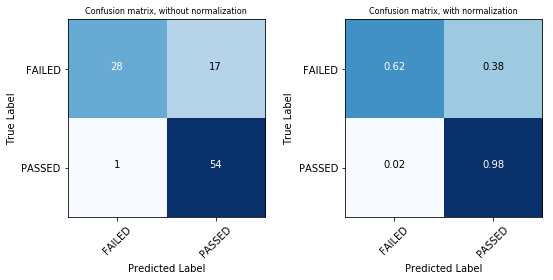

In [64]:
plt.figure(figsize=(8, 4))

cnf_matrix = confusion_matrix(res['actual'], res['pred_class'])
class_names = ['FAILED', 'PASSED']

ax = plt.subplot(1, 2, 1)
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix, without normalization')

ax = plt.subplot(1, 2, 2)
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Confusion matrix, with normalization')

plt.savefig('../slides/figures/exam-performance-lr-confusion-matrix.pdf', transparent=True, bbox_inches='tight', pad_inches=0)

### Development Exercise

In [65]:
prediction_set = pd.DataFrame({'hours_studied': [4], 'hours_slept': [10]})
prediction = pipeline.predict(prediction_set)
prediction_proba = pipeline.predict_proba(prediction_set)
print(f'Prediction: {prediction[0]}, Probability Estimate: {prediction_proba[0][1]}')

Prediction: 1, Probability Estimate: 0.9010322052238752


In [66]:
%%writefile ../slides/snippets/rental-prices-mlr-prediction-set.py
prediction_set = pd.DataFrame({'hours_studied': [4], 'hours_slept': [10]})

Writing ../slides/snippets/rental-prices-mlr-prediction-set.py


In [67]:
%%writefile ../slides/snippets/rental-prices-mlr-prediction-probability.py
prediction_proba = pipeline.predict_proba(prediction_set)

Writing ../slides/snippets/rental-prices-mlr-prediction-probability.py
